In [1]:
import matplotlib
import cv2
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pathlib

Using TensorFlow backend.


In [2]:
data = []
labels = []

#берём пути к изображениям и рандомно перемешиваем
data_root = pathlib.Path("C:\\UIR\\samples\\sample_1\\1000\\cut_letters")
imagePaths = list(data_root.glob('*/*'))
imagePaths = [str(path) for path in imagePaths]
random.shuffle(imagePaths)

#цикл по изображениям
for imagePath in imagePaths:
    #загружаем изображение, меняем размер на 28x28 пикселей и добавляем в список
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(28,28))
    data.append(image)
    
    #извлекаем метку класса из пути к изображению и обновляем список меток
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [3]:
# масштабируем интенсивности пикселей из диапазона [0,255] -> в диапазон [0, 1]
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)

In [4]:
# разбиваем данные на обучающую и тестовую выборки, используя 75% 
# данных для обучения и оставшиеся 25% для тестирования
(trainX,testX, trainY,testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)
print(testX.shape)
print(trainX.shape)

(9100, 28, 28, 3)
(27300, 28, 28, 3)


In [5]:
#Конвертируем метки из целых чисел в векторы
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY) #находит все уникальные метки класса в testY, а затем преобразует их в метки One-Hot Encoding
testY = lb.transform(testY) #выполняет один шаг One-Hot Encoding исходя из найденных уникальных меток на предыдущем шаге

In [6]:
print('X_train shape:', trainX.shape)
print(trainX.shape[0], 'train samples')
print(testX.shape[0], 'test samples')

X_train shape: (27300, 28, 28, 3)
27300 train samples
9100 test samples


## CNN Architecture

In [13]:
EPOCHS = 30
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3) #input_shape будет равен 28x28x3
num_classes = 28


model = Sequential()
model.add(Conv2D(filters=15,kernel_size=(9, 9),strides=(1, 1), activation='sigmoid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))
model.add(Conv2D(filters=15,kernel_size=(9, 9),strides=(1, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())
model.add(Dense(150, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#Компилируем модель, используя adadelta как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь. Добавляем метрики
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [14]:
#отобразим получившуюся модель
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 20, 20, 15)        3660      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 15)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 15)          18240     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               2400      
_________________________________________________________________
dense_6 (Dense)              (None, 28)               

In [15]:
from keras import callbacks

In [16]:
#подключаем колбаски для работы tensorboard
#write tensorboard --logdir C:/UIR/network_04/logs in cmd
my_callbacks = [
    callbacks.TensorBoard(log_dir="C:\\UIR\\network_04\\logs", histogram_freq = 1, write_graph = True, write_images = True)
]

In [17]:
H = model.fit(trainX, trainY, verbose=2, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32, callbacks=my_callbacks)

Train on 27300 samples, validate on 9100 samples
Epoch 1/30
 - 12s - loss: 1.9487 - accuracy: 0.5628 - val_loss: 0.5982 - val_accuracy: 0.9379
Epoch 2/30
 - 13s - loss: 0.2554 - accuracy: 0.9693 - val_loss: 0.0934 - val_accuracy: 0.9924
Epoch 3/30
 - 14s - loss: 0.0536 - accuracy: 0.9948 - val_loss: 0.0388 - val_accuracy: 0.9947
Epoch 4/30
 - 12s - loss: 0.0277 - accuracy: 0.9961 - val_loss: 0.0287 - val_accuracy: 0.9954
Epoch 5/30
 - 12s - loss: 0.0197 - accuracy: 0.9967 - val_loss: 0.0240 - val_accuracy: 0.9959
Epoch 6/30
 - 12s - loss: 0.0151 - accuracy: 0.9975 - val_loss: 0.0210 - val_accuracy: 0.9962
Epoch 7/30
 - 12s - loss: 0.0123 - accuracy: 0.9981 - val_loss: 0.0198 - val_accuracy: 0.9966
Epoch 8/30
 - 12s - loss: 0.0107 - accuracy: 0.9982 - val_loss: 0.0188 - val_accuracy: 0.9965
Epoch 9/30
 - 13s - loss: 0.0088 - accuracy: 0.9985 - val_loss: 0.0170 - val_accuracy: 0.9967
Epoch 10/30
 - 13s - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0155 - val_accuracy: 0.9969
Epoch 11/3

In [18]:
model.save('model_04.h5')
f = open("C:\\UIR\\network_04\\bin_class.txt", "wb")
f.write(pickle.dumps(lb))
f.close()

## Plots

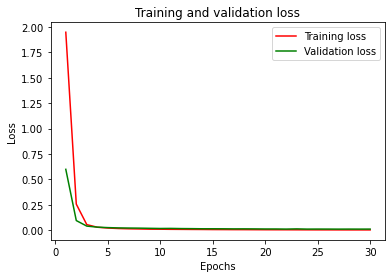

In [19]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

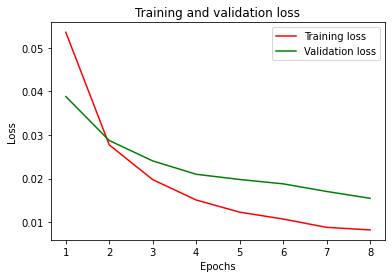

In [26]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
loss = loss[2:10]
val_loss = H.history['val_loss']
val_loss = val_loss[2:10]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

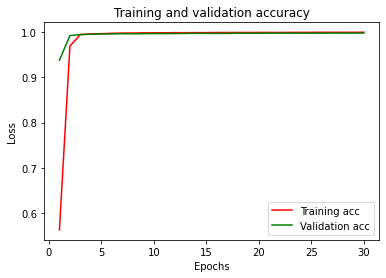

In [22]:
#plotting training and validation accuracy
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

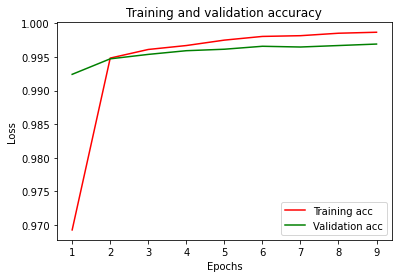

In [28]:
#plotting training and validation accuracy
acc = H.history['accuracy']
acc = acc[1:10]
val_acc = H.history['val_accuracy']
val_acc = val_acc[1:10]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

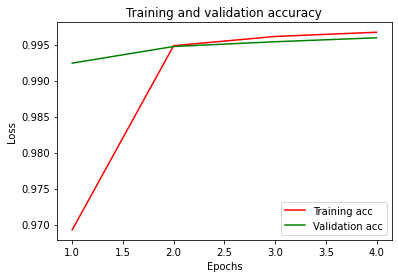

In [35]:
#plotting training and validation accuracy
acc = H.history['accuracy']
acc = acc[1:5]
val_acc = H.history['val_accuracy']
val_acc = val_acc[1:5]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()